## 民泊サービスの宿泊料金予測
- 一泊の適正価格はいくら？
- LightGBM重要度評価

### Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'

Mounted at /content/drive
/content/drive/My Drive


### ライブラリのインストール、インポート

In [ ]:
# カレントディレクトリを変更
import os
os.chdir('/content/drive/My Drive/Probdata/airbnb/')
print(os.getcwd())

/content/drive/My Drive/Probdata/airbnb


In [ ]:
class Config():
    root_path = './'
    input_path = os.path.join(root_path, 'input')
    output_path = os.path.join(root_path, 'output')
    intermediate_path = os.path.join(root_path, 'intermediate')
    seed = 42
    debug = False

In [ ]:
import pandas as pd
import numpy as np
import warnings
import datetime
import matplotlib.pyplot as plt

import scipy.stats as stats
from geopy.distance import geodesic

import sklearn
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

### データの読み込み

In [ ]:
train_df = pd.read_csv(f'{Config.intermediate_path}/train_tmp.csv')
test_df = pd.read_csv(f'{Config.intermediate_path}/test_tmp.csv')
submission_df = pd.read_csv(f'{Config.input_path}/submission.csv')

## LGBMの実行前準備

In [ ]:
# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df): 
    n_features = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot['feature'].values             # 特徴量の取得 
    plt.yticks(np.arange(n_features), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル

In [ ]:
# columnsをターゲット変数とtargetとカテゴリカル変数に分割
target_column = "y"
category_column = ['neighbourhood', 'room_type', 'sta_nm_1', 'sta_nm_2', 'sta_nm_3']
standard_column = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365', 
                   'dis_200', 'dis_500', 'dis_1000', 'date_cnt']

y = train_df[target_column]
X = train_df[category_column]
test_X = test_df[category_column]

traintest = pd.concat([X, test_X], ignore_index = True)

In [ ]:
# 説明変数をラベルエンコーディング
warnings.simplefilter('ignore')
for column in traintest.columns:
    le = preprocessing.LabelEncoder()
    target_column = traintest[column]
    train_target_column = X[column]
    test_target_column = test_X[column]  
    le.fit(target_column)
    train_label_encoded_column = le.transform(train_target_column)
    test_label_encoded_column = le.transform(test_target_column)
    X[column] = pd.Series(train_label_encoded_column).astype("category")
    test_X[column] = pd.Series(test_label_encoded_column).astype("category")

In [ ]:
X = pd.concat([X, train_df[standard_column]], axis=1)
test_X = pd.concat([test_X, test_df[standard_column]], axis=1)

In [ ]:
X['dis'] = X['dis_200'] + X['dis_500'] + X['dis_1000']
test_X['dis'] = test_X['dis_200'] + test_X['dis_500'] + test_X['dis_1000']

In [ ]:
print(X.shape, test_X.shape)

(9990, 14) (4996, 14)


## LGBMの実行

In [ ]:
# 目的変数を対数化
y = np.log1p(y) 
# トレーニングデータ,テストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=Config.seed)

In [ ]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train) 

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression', # 目的 : 回帰  
        'metric': 'rmse', # 評価指標 : rsme(平均二乗誤差の平方根) 
        "verbosity": -1,
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

[1]	valid_0's rmse: 0.947531
[2]	valid_0's rmse: 0.918915
[3]	valid_0's rmse: 0.894614
[4]	valid_0's rmse: 0.873159
[5]	valid_0's rmse: 0.855456
[6]	valid_0's rmse: 0.841267
[7]	valid_0's rmse: 0.828417
[8]	valid_0's rmse: 0.818227
[9]	valid_0's rmse: 0.808511
[10]	valid_0's rmse: 0.800606
[11]	valid_0's rmse: 0.79453
[12]	valid_0's rmse: 0.787666
[13]	valid_0's rmse: 0.782183
[14]	valid_0's rmse: 0.77621
[15]	valid_0's rmse: 0.771485
[16]	valid_0's rmse: 0.767291
[17]	valid_0's rmse: 0.763608
[18]	valid_0's rmse: 0.760493
[19]	valid_0's rmse: 0.757906
[20]	valid_0's rmse: 0.755369
[21]	valid_0's rmse: 0.752901
[22]	valid_0's rmse: 0.751022
[23]	valid_0's rmse: 0.7488
[24]	valid_0's rmse: 0.746717
[25]	valid_0's rmse: 0.744595
[26]	valid_0's rmse: 0.742549
[27]	valid_0's rmse: 0.740874
[28]	valid_0's rmse: 0.739081
[29]	valid_0's rmse: 0.737415
[30]	valid_0's rmse: 0.735413
[31]	valid_0's rmse: 0.734058
[32]	valid_0's rmse: 0.732417
[33]	valid_0's rmse: 0.730605
[34]	valid_0's rmse: 0.

In [ ]:
# 特徴量重要度の算出 (データフレームで取得)
cols = list(X.columns)       # 特徴量名のリスト(目的変数CRIM以外)
# 特徴量重要度の算出方法 'gain'(推奨) : トレーニングデータの損失の減少量を評価
f_importance = np.array(model.feature_importance(importance_type='gain')) # 特徴量重要度の算出 //
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

,feature,importance
1,room_type,0.212925
2,sta_nm_1,0.191446
3,sta_nm_2,0.122516
8,availability_365,0.112119
4,sta_nm_3,0.083839
5,minimum_nights,0.062527
7,reviews_per_month,0.048120
6,number_of_reviews,0.040237
0,neighbourhood,0.035163
12,date_cnt,0.031352


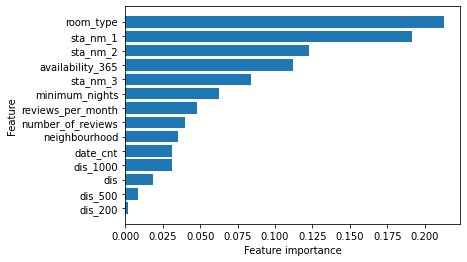

In [ ]:
# 特徴量重要度の可視化
plot_feature_importance(df_importance)

In [ ]:
X.head()

,neighbourhood,room_type,sta_nm_1,sta_nm_2,sta_nm_3,minimum_nights,number_of_reviews,reviews_per_month,availability_365,dis_200,dis_500,dis_1000,date_cnt,dis
0,9,0,276,335,224,1,55,2.21,173,0,1,2,-4,3
1,21,0,71,416,0,6,72,2.11,9,1,0,1,-35,2
2,7,0,112,109,0,1,18,3.46,288,0,1,1,-37,2
3,16,0,80,356,133,1,2,1.76,87,0,0,3,-27,3
4,18,0,223,178,332,1,86,2.00,156,0,3,4,-90,7
